<p style="font-size: 32px; font-weight: 500;">Activities in Milan, Italy</p>

<h2 id="tocheading">Table of Contents</h2>
<div id="toc"></div>

In [1]:
%%javascript
$.getScript("./table_of_contents.js")

<IPython.core.display.Javascript object>

## Prerequisites

### Import the necessary libraries for the project

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import ipywidgets as widgets
import requests
import math
import time
import statistics
import folium
import re

from bs4 import BeautifulSoup
from geopy import distance
from geopy.geocoders import Here
from sklearn.cluster import KMeans

### Define External APIs Credentials

In [3]:
# Here
HERE_APP_ID = "ftdKFJQyxoPzFXNFyvHn"
HERE_APP_CODE = "r9u4iqtfjYiVQRW4Ssr17Q"

# Foursquare
FOURSQUARE_CLIENT_ID = "XBLACQJIWF5043SZHM3YP1DHNROR354MB423U3JNXZZ00MXC"
FOURSQUARE_CLIENT_SECRET = "HYNP2IOFBZ2SQS4IEMDG211KJXZOAQ12PZ0NVBN40AU2L1QR"
FOURSQUARE_VERSION = "20180604"
FOURSQUARE_LIMIT = 1024

## Web Scraping

### Define the wikipedia page for web scraping

In [4]:
wiki_url = "https://en.wikipedia.org/wiki/Category:Districts_of_Milan"

### Download the web page html content

In [5]:
response = requests.get(wiki_url)
html = response.text
print("Response status code:", response.status_code)

Response status code: 200


In [6]:
soup = BeautifulSoup(html, "html")

# Partially print the downloaded HTML page
pretty_html = soup.prettify()
pretty_html_omitted = pretty_html[:1024] + "...".join(["\n"] * 6) + pretty_html[-1024:]
print(pretty_html_omitted)

<!DOCTYPE html>
<html class="client-nojs" dir="ltr" lang="en">
 <head>
  <meta charset="utf-8"/>
  <title>
   Category:Districts of Milan - Wikipedia
  </title>
  <script>
   document.documentElement.className=document.documentElement.className.replace(/(^|\s)client-nojs(\s|$)/,"$1client-js$2");RLCONF={"wgCanonicalNamespace":"Category","wgCanonicalSpecialPageName":!1,"wgNamespaceNumber":14,"wgPageName":"Category:Districts_of_Milan","wgTitle":"Districts of Milan","wgCurRevisionId":899922759,"wgRevisionId":899922759,"wgArticleId":19192884,"wgIsArticle":!0,"wgIsRedirect":!1,"wgAction":"view","wgUserName":null,"wgUserGroups":["*"],"wgCategories":["Commons category link is on Wikidata","Subdivisions of Milan","City districts"],"wgBreakFrames":!1,"wgPageContentLanguage":"en","wgPageContentModel":"wikitext","wgSeparatorTransformTable":["",""],"wgDigitTransformTable":["",""],"wgDefaultDateFormat":"dmy","wgMonthNames":["","January","February","March","April","May","June","July","August","Septem

### Find the target table from the web page

In [7]:
html_table = soup.find("div", {"class": "mw-category"})

### Extract the data from the table

In [8]:
# Define function to extract all districs from a specific group. Returns a list of strings
def extract_districts_from_group(group):
    return list(map(lambda item: item.a.get_text(), group.ul.find_all("li")))
    
# Define function to extract the groups from the table
def extract_groups(table):
    return table.find_all("div", {"class": "mw-category-group"})

# Get the ditrict groups
district_groups = list(map(extract_districts_from_group, extract_groups(html_table)))
districts = [district for group in district_groups for district in group]
districts

['Affori',
 'Assiano',
 'Baggio (district of Milan)',
 'Barona',
 'Bicocca (district of Milan)',
 'Bovisa',
 'Bovisasca',
 'Brera (district of Milan)',
 'Bruzzano',
 'Calvairate',
 'Centro Direzionale di Milano',
 'Chiaravalle (district of Milan)',
 'Chinatown, Milan',
 'Cimiano',
 'Città Studi',
 'Comasina',
 'Crescenzago',
 'Dergano',
 'Figino (district of Milan)',
 'Forlanini (district of Milan)',
 'Gallaratese',
 'Garegnano',
 'Ghisolfa',
 'Giambellino-Lorenteggio',
 'Gorla',
 'Gratosoglio',
 'Greco (district of Milan)',
 'Lambrate',
 'Lampugnano',
 'Milano Santa Giulia',
 'Monluè',
 'Morivione',
 'Muggiano (district of Milan)',
 'Niguarda',
 'Nosedo',
 'Ortica',
 'Ponte Lambro (district of Milan)',
 'Porta Garibaldi (Milan)',
 'Porta Genova',
 'Porta Lodovica',
 'Porta Magenta',
 'Porta Monforte',
 'Porta Nuova (Milan)',
 'Porta Romana (Milan)',
 'Porta Sempione',
 'Porta Tenaglia',
 'Porta Ticinese',
 'Porta Venezia',
 'Porta Vigentina',
 'Porta Vittoria',
 'Porta Volta',
 'Porte

## Process and Clean-up the Data

In Milan, there is a region, named **Quadrilatero della moda**, that not all geocoders are able to geocode. In order to prevent it, disregard this region.

In [9]:
districts = list(filter(lambda district: district != "Quadrilatero della moda", districts))

Clean the data:
* Remove anything in braces.
* Delete anything after the first comma character.

In [10]:
districts = list(map(lambda string: re.sub("\([^)]+\)", "", string).split(",")[0].strip(), districts))

See how many districts there are in Milan, Italy:

In [11]:
print("In Milan, Italy, there is a total of {} districts.".format(len(districts)))

In Milan, Italy, there is a total of 75 districts.


## District Geocoding

### Use HERE geocoding capabilities to convert district name to geo-coordinates

In [12]:
here_geocoder = Here(HERE_APP_ID, HERE_APP_CODE)

# Define the method for geocoding
def geocode_location(location_name):

    # Send the geocoding request
    response = here_geocoder.geocode(query = location_name, exactly_one = True)

    try:
        # Get the coordinates of the location, bounding box top-left coordinates and bottom-right coordinates
        location_coordinates = (response.latitude, response.longitude)
        map_view_dict = response.raw["Location"]["MapView"]
        top_left_coordinates = (map_view_dict["TopLeft"]["Latitude"],
                                map_view_dict["TopLeft"]["Longitude"])
        bottom_right_coordinates = (map_view_dict["BottomRight"]["Latitude"],
                                    map_view_dict["BottomRight"]["Longitude"])
        half_diagonal = statistics.mean([
            distance.distance(location_coordinates, top_left_coordinates).meters,
            distance.distance(location_coordinates, bottom_right_coordinates).meters])
        radius = half_diagonal / math.sqrt(math.pi)
        
        # Return the results
        return (location_coordinates, radius, location_name)
    except:

        # An error has occurred, location could not be geocoded
        return (None, 0, location_name)

print("Start geocoding districts in Milan…")

# Geocode all district names to geo-coordinates
districts_coordinates = list(map(geocode_location,
                                 map(lambda district: "{}, Milan, Italy".format(district), districts)))
print("Geocoding finished!")

Start geocoding districts in Milan…
Geocoding finished!


Create a Pandas' dataframe from the geocoding results.

In [13]:
# Change the formating of the response and create the dataframe
df_list = map(lambda districts_coordinate:
              (districts_coordinate[2],
               districts_coordinate[0][0],
               districts_coordinate[0][1],
               districts_coordinate[1]), districts_coordinates)
df = pd.DataFrame(df_list, columns = ["Name", "Latitude", "Longitude", "Radius"])

In [14]:
print("{}\n".format(df.head(10)))
print("Min radius value is: {:.2f} meters".format(df["Radius"].min()))
print("Mean radius value is: {:.2f} meters".format(df["Radius"].mean()))
print("Max radius value is: {:.2f} meters".format(df["Radius"].max()))

                       Name  Latitude  Longitude       Radius
0      Affori, Milan, Italy  45.51411    9.17353  1062.274843
1     Assiano, Milan, Italy  45.45053    9.06172   309.956481
2      Baggio, Milan, Italy  45.46325    9.09271  1397.885267
3      Barona, Milan, Italy  45.43372    9.15160   904.160261
4     Bicocca, Milan, Italy  45.52150    9.21326   852.057954
5      Bovisa, Milan, Italy  45.50314    9.16123   827.198327
6   Bovisasca, Milan, Italy  45.51556    9.15095   571.968241
7       Brera, Milan, Italy  45.47149    9.18773   394.205928
8    Bruzzano, Milan, Italy  45.52825    9.18071   838.205252
9  Calvairate, Milan, Italy  45.45618    9.22488   680.692365

Min radius value is: 26.02 meters
Mean radius value is: 717.85 meters
Max radius value is: 7085.78 meters


It is noticeable that the **minimum** and **maximum** radius values are quite far from the **mean** value. Update the data and replace these values with the **mean** value.

In [15]:
value_out_of_range = lambda value: True if value > 5000.0 or value < 100.0 else False
mean_value = df["Radius"][df["Radius"].map(value_out_of_range) == False].mean()

print("Mean radius value (without out-of-range values) is: {:.2f} meters".format(mean_value))

df["Radius"] = df["Radius"].apply(lambda x: mean_value if value_out_of_range(x) else x)

Mean radius value (without out-of-range values) is: 674.39 meters


In [16]:
print("Min radius value is: {:.2f} meters".format(df["Radius"].min()))
print("Mean radius value is: {:.2f} meters".format(df["Radius"].mean()))
print("Max radius value is: {:.2f} meters".format(df["Radius"].max()))

Min radius value is: 105.84 meters
Mean radius value is: 674.39 meters
Max radius value is: 1397.89 meters


The marginal values are now much closer to the mean value: save the dataframe to a file.

In [17]:
df.to_csv("milan_districts.csv", index = None, header = True)

See the final dataframe with Milan's districts.

In [18]:
df

,Name,Latitude,Longitude,Radius
0,"Affori, Milan, Italy",45.51411,9.17353,1062.274843
1,"Assiano, Milan, Italy",45.45053,9.06172,309.956481
2,"Baggio, Milan, Italy",45.46325,9.09271,1397.885267
3,"Barona, Milan, Italy",45.43372,9.15160,904.160261
4,"Bicocca, Milan, Italy",45.52150,9.21326,852.057954
5,"Bovisa, Milan, Italy",45.50314,9.16123,827.198327
6,"Bovisasca, Milan, Italy",45.51556,9.15095,571.968241
7,"Brera, Milan, Italy",45.47149,9.18773,394.205928
8,"Bruzzano, Milan, Italy",45.52825,9.18071,838.205252
9,"Calvairate, Milan, Italy",45.45618,9.22488,680.692365


### Visualize districts in Milan

In [19]:
# Geocode Milan latitude and longitude
milan_location = here_geocoder.geocode(query = "Milan, Italy", exactly_one = True)

In [20]:
# Create map of Milan, Italy using latitude and longitude values
map_milan = folium.Map(location = [milan_location.latitude, milan_location.longitude], zoom_start = 11)

# Add district circles to the map
for lat, long, radius, district_name in zip(df["Latitude"], df["Longitude"], df["Radius"], df["Name"]):

    # Circle properties
    label = folium.Popup("{}".format(district_name))
    fill_color = tuple(np.random.choice(range(256), size = 3))
    border_color = tuple(map(lambda x: int(x - x * 0.05), fill_color))

    # Create the circle and add it to the map
    folium.Circle([lat, long],
                  radius = radius,
                  popup = label,
                  color = "rgb{}".format(border_color),
                  fill = True,
                  fill_color = "rgb{}".format(fill_color),
                  fill_opacity = 0.5,
                  opacity = 0.75,
                  weight = 1.0).add_to(map_milan)
map_milan

## Explore Venues in Milan

### Get the venues in a random district from Milan

First of all, get a random district.

In [21]:
milan_random_district = df.sample().iloc[0]
milan_random_district

Name         Porta Lodovica, Milan, Italy
Latitude                          45.4532
Longitude                          9.1893
Radius                             567.69
Name: 39, dtype: object

Define a method that would extract the venues within a specific region.

In [22]:
def get_venues(lat, long, radius, limit = FOURSQUARE_LIMIT):

    # Define the Foursquare URL
    url = (
        "https://api.foursquare.com/v2/venues/explore?"
        "client_id={0}&client_secret={1}&ll={2},{3}&v={4}&radius={5:.2f}&limit={6:d}"
    ).format(FOURSQUARE_CLIENT_ID, FOURSQUARE_CLIENT_SECRET, lat, long, FOURSQUARE_VERSION, radius, limit)

    # Send the request
    response = requests.get(url).json()["response"]

    # Parse the response
    def parse_venue(venue):
        try:
            return (venue["venue"]["name"],
                    venue["venue"]["categories"][0]["name"],
                    venue["venue"]["location"]["lat"],
                    venue["venue"]["location"]["lng"])
        except:
            return None

    return list(filter(None.__ne__, map(parse_venue, response["groups"][0]["items"])))

In [23]:
# Get the venues from for the selected district
milan_random_district_venues = get_venues(milan_random_district["Latitude"],
                                          milan_random_district["Longitude"],
                                          max(500, milan_random_district["Radius"]))

# Transform the list to a dataframe for easier visualization
df_milan_random_district = pd.DataFrame(milan_random_district_venues,
                                        columns = ["Name", "Category", "Latitude", "Longitude"])
df_milan_random_district

,Name,Category,Latitude,Longitude
0,Panini Durini,Café,45.450677,9.190446
1,La Boutique del Panino e Della Birra,Food Truck,45.451884,9.186108
2,El Porteño,Argentinian Restaurant,45.452671,9.184385
3,Mi-Ramen Bistrò,Ramen Restaurant,45.451958,9.185402
4,Gattullo,Dessert Shop,45.451962,9.186006
5,Viva Lodovica,Salad Place,45.451882,9.186328
6,Venti136,Lounge,45.451689,9.187482
7,La Strada,Pub,45.451381,9.193973
8,Osteria dell'Oca Giuliva,Restaurant,45.450975,9.193636
9,Roqus,Pizza Place,45.451947,9.187470


Visualize the venues in this district.

In [24]:
# Create map of Milan, Italy using latitude and longitude values of the random district
map_milan_random_district = folium.Map(location = [milan_random_district["Latitude"],
                                                   milan_random_district["Longitude"]],
                                       tiles = "Stamen Terrain",
                                       zoom_start = 15)

# Add venue circle markers to the map
for name, category, lat, long in milan_random_district_venues:

    # Circle properties
    label = folium.Popup("{0} ({1})".format(name, category))
    fill_color = tuple(np.random.choice(range(256), size = 3))
    border_color = tuple(map(lambda x: int(x - x * 0.05), fill_color))

    # Create the circle and add it to the map
    folium.CircleMarker([lat, long],
                  radius = 5,
                  popup = label,
                  color = "rgb{}".format(border_color),
                  fill = True,
                  fill_color = "rgb{}".format(fill_color),
                  fill_opacity = 0.75,
                  opacity = 0.75,
                  weight = 2.0).add_to(map_milan_random_district)
map_milan_random_district

Get all unique venue categories in this district.

In [25]:
print("There are {} uniques categories in {}:\n\n{}"
      .format(len(df_milan_random_district["Category"].unique()),
              milan_random_district["Name"],
              df_milan_random_district["Category"].unique()))

There are 32 uniques categories in Porta Lodovica, Milan, Italy:

['Café' 'Food Truck' 'Argentinian Restaurant' 'Ramen Restaurant'
 'Dessert Shop' 'Salad Place' 'Lounge' 'Pub' 'Restaurant' 'Pizza Place'
 'Cocktail Bar' 'Chinese Restaurant' 'Hotel' 'Plaza' 'Wine Bar'
 'Burger Joint' 'Bistro' 'Italian Restaurant' 'Ice Cream Shop' 'Theater'
 'Sporting Goods Shop' 'Boutique' 'Gym / Fitness Center'
 'Fish & Chips Shop' 'Seafood Restaurant' 'Indian Restaurant'
 'Sandwich Place' 'Sushi Restaurant' 'Kebab Restaurant' 'Piadineria'
 'Modern European Restaurant' 'Tram Station']


List the most frequent types of venues in the following district.

In [26]:
df_milan_random_district.groupby("Category").count().sort_values("Name", ascending = False)["Name"]

Category
Hotel                         5
Café                          4
Burger Joint                  3
Restaurant                    3
Pizza Place                   3
Italian Restaurant            3
Lounge                        2
Sushi Restaurant              2
Sandwich Place                2
Piadineria                    2
Bistro                        2
Wine Bar                      2
Cocktail Bar                  2
Ice Cream Shop                1
Indian Restaurant             1
Tram Station                  1
Theater                       1
Boutique                      1
Sporting Goods Shop           1
Seafood Restaurant            1
Chinese Restaurant            1
Salad Place                   1
Ramen Restaurant              1
Pub                           1
Plaza                         1
Dessert Shop                  1
Fish & Chips Shop             1
Modern European Restaurant    1
Food Truck                    1
Kebab Restaurant              1
Gym / Fitness Center          1

### Get the venues for all the districts from Milan

In [27]:
milan_venues = []

# Download the venues for every district and append them to `milan venues` list
for idx, row in df.iterrows():
    venues = list(map(lambda v: (row["Name"], row["Latitude"], row[ "Longitude"], v[0], v[1], v[2], v[3]),
                      get_venues(row["Latitude"], row["Longitude"], max(500, row["Radius"]))))
    milan_venues.extend(venues)

print("Foursquare provided {} venues for all the districts in Milan.".format(len(milan_venues)))

Foursquare provided 2838 venues for all the districts in Milan.


In [28]:
# Transform the list to a dataframe for easier visualization
df_milan_venues = pd.DataFrame(milan_venues,
                               columns = ["District Name", "District Latitude", "District Longitude",
                                          "Venue Name", "Venue Category", "Venue Latitude", "Venue Longitude"])
# View some of the venues from Milan
df_milan_venues.sample(24)

,District Name,District Latitude,District Longitude,Venue Name,Venue Category,Venue Latitude,Venue Longitude
850,"Lambrate, Milan, Italy",45.48157,9.25173,Ribs and Beer,Steakhouse,45.481188,9.245182
126,"Bovisa, Milan, Italy",45.50314,9.16123,Naxos,Sicilian Restaurant,45.502123,9.162126
1919,"Porta Venezia, Milan, Italy",45.47098,9.19981,Giardini di Villa Reale,Park,45.472127,9.199721
2792,"Villapizzone, Milan, Italy",45.49835,9.14454,L'Immagine,Italian Restaurant,45.497218,9.145811
309,"Bruzzano, Milan, Italy",45.52825,9.18071,fermata 40 Galeazzi,Bus Station,45.522574,9.174539
1188,"Porta Genova, Milan, Italy",45.45791,9.17457,Yum - Taste of Philippines,Filipino Restaurant,45.457560,9.168572
2816,"Villapizzone, Milan, Italy",45.49835,9.14454,Pizzeria al Trancio,Pizza Place,45.500819,9.141732
1267,"Porta Lodovica, Milan, Italy",45.45319,9.18930,Spoon restaurant & lounge,Modern European Restaurant,45.451612,9.194451
410,"Chinatown, Milan, Italy",45.46796,9.18178,Piazza Cordusio,Plaza,45.465508,9.186150
1303,"Porta Magenta, Milan, Italy",45.46582,9.17800,Kasanova,Kitchen Supply Store,45.467689,9.174979


Save the Milan venues to a file.

In [29]:
df_milan_venues.to_csv("milan_venues.csv", index = None, header = True)

### Analyze venue categories in Milan

Get all unique venue categories of all the retrieved venues in Milan, Italy.

In [30]:
print("There are {} uniques categories:\n\n{}".format(len(df_milan_venues["Venue Category"].unique()),
                                                      df_milan_venues["Venue Category"].unique()))

There are 274 uniques categories:

['Hotel' 'Supermarket' 'Pizza Place' 'Kebab Restaurant' 'Pool Hall' 'Park'
 'Hotel Bar' 'Hobby Shop' 'Brewery' 'Health Food Store'
 'Italian Restaurant' 'Soccer Field' 'Fried Chicken Joint' 'Café'
 'Gym / Fitness Center' 'Cocktail Bar' 'Salon / Barbershop' 'Rock Club'
 'Japanese Restaurant' 'Shipping Store' 'Skate Park' 'Football Stadium'
 'Furniture / Home Store' 'Bar' 'Plaza' 'Bus Station' 'Volleyball Court'
 'Campground' 'Bakery' 'Trattoria/Osteria' 'Theater' 'Pub'
 'Tennis Stadium' 'Athletics & Sports' 'Gym' 'Ice Cream Shop'
 'Art Gallery' 'Piadineria' 'Sandwich Place' 'Seafood Restaurant'
 'Multiplex' 'Frozen Yogurt Shop' 'Restaurant' 'Steakhouse'
 'German Restaurant' 'Shopping Mall' 'Music Venue' 'Sardinian Restaurant'
 'Diner' 'Beer Bar' 'Sushi Restaurant' 'Electronics Store'
 'Breakfast Spot' 'Fast Food Restaurant' 'Gym Pool' 'Bistro'
 'Dance Studio' 'Food Court' 'Paper / Office Supplies Store' 'Ballroom'
 'Creperie' 'Sicilian Restaurant' 'Sna

List the most frequent types of venues in Milan.

In [31]:
top_venue_categories = df_milan_venues.groupby("Venue Category")["Venue Category"].count()\
    .sort_values(ascending = False)[:16].to_frame()
top_venue_categories

,Venue Category
Venue Category,
Italian Restaurant,304
Pizza Place,180
Café,153
Hotel,126
Ice Cream Shop,98
Restaurant,83
Plaza,75
Supermarket,69
Bakery,59


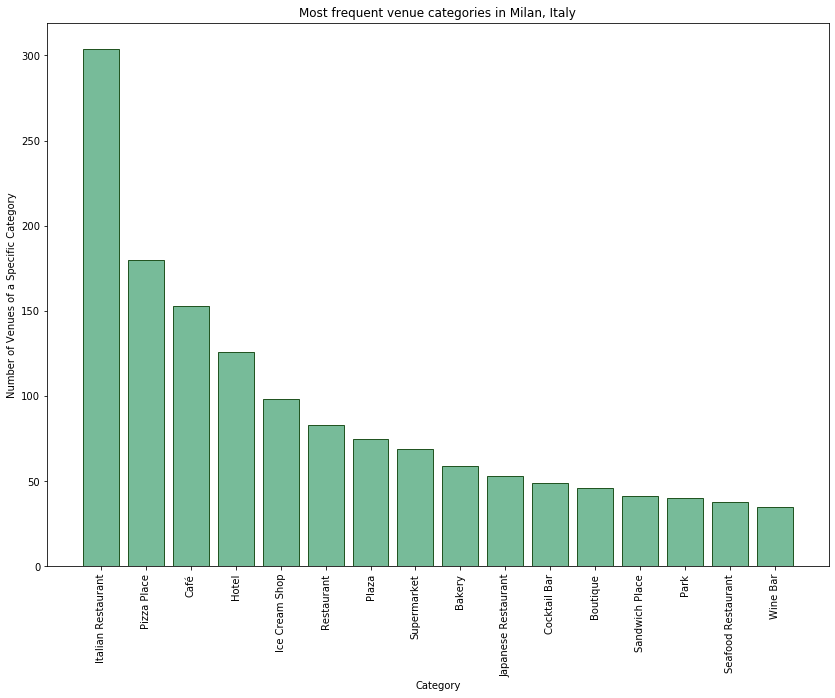

In [32]:
categories, counts = zip(*map(lambda row: (row[0], row[1][0]), top_venue_categories.iterrows()))

# Histogram
plt.rcParams["figure.figsize"] = (14, 10)
plt.bar(range(0, len(counts)), counts, color = "#77BB99", edgecolor = "#225522")
plt.title("Most frequent venue categories in Milan, Italy")
plt.xlabel("Category")
plt.ylabel("Number of Venues of a Specific Category")
plt.xticks(range(0, len(counts)), categories, rotation = "vertical")
plt.show()

## Analyze Each District in Milan

### Apply venue category one-hot encoding in the dataframe

In [33]:
# One-hot encoding
df_milan_onehot = pd.get_dummies(df_milan_venues[["Venue Category"]], prefix = "", prefix_sep = "")

# Add district column back to the dataframe
df_milan_onehot["District Name"] = df_milan_venues["District Name"] 
df_milan_onehot = df_milan_onehot[[df_milan_onehot.columns[-1]] + list(df_milan_onehot.columns[:-1])]

### Examine the new dataframe

In [34]:
# View the one-hot encoded dataframe
df_milan_onehot.head()

,District Name,Accessories Store,Adult Education Center,African Restaurant,Airport,Airport Terminal,American Restaurant,Amphitheater,Argentinian Restaurant,Art Gallery,...,Video Game Store,Vietnamese Restaurant,Volleyball Court,Watch Shop,Whisky Bar,Wine Bar,Wine Shop,Winery,Women's Store,Yoga Studio
0,"Affori, Milan, Italy",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,"Affori, Milan, Italy",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,"Affori, Milan, Italy",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,"Affori, Milan, Italy",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,"Affori, Milan, Italy",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [35]:
df_milan_onehot.shape

(2838, 275)

### Group rows by district by taking the mean of the frequency of occurrence for each venue category

In [36]:
df_milan_grouped = df_milan_onehot.groupby("District Name").mean().reset_index()
df_milan_grouped.head()

,District Name,Accessories Store,Adult Education Center,African Restaurant,Airport,Airport Terminal,American Restaurant,Amphitheater,Argentinian Restaurant,Art Gallery,...,Video Game Store,Vietnamese Restaurant,Volleyball Court,Watch Shop,Whisky Bar,Wine Bar,Wine Shop,Winery,Women's Store,Yoga Studio
0,"Affori, Milan, Italy",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,"Assiano, Milan, Italy",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,"Baggio, Milan, Italy",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.071429,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,"Barona, Milan, Italy",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,"Bicocca, Milan, Italy",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.016393,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [37]:
df_milan_grouped.shape

(75, 275)

### Examine each district along with the most common venue categories

In [38]:
top_limit = 12

def most_common_venues(row, top_venues_limit):
    venue_categories_sorted = row.iloc[1:].sort_values(ascending = False)
    return venue_categories_sorted.index.values[:top_venues_limit]

# Create the columns according to number of top venues limit
columns = ["District Name"]
indicators = ["st", "nd", "rd", "th"]

for idx in np.arange(top_limit):
    try:
        columns.append('{}{} Most Common Venue'.format(idx + 1, indicators[min(idx, len(indicators))]))
    except:
        columns.append('{}th Most Common Venue'.format(idx + 1))

# Create the new dataframe
df_milan_sorted_top = pd.DataFrame(columns = columns)
df_milan_sorted_top["District Name"] = df_milan_grouped["District Name"]

for idx in np.arange(df_milan_grouped.shape[0]):
    df_milan_sorted_top.iloc[idx, 1:] = most_common_venues(df_milan_grouped.iloc[idx, :], top_limit)

# View the 12 most common venue categories for the first 12 districts in Milan
df_milan_sorted_top.head(12)

,District Name,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,11th Most Common Venue,12th Most Common Venue
0,"Affori, Milan, Italy",Hotel,Pizza Place,Park,Soccer Field,Italian Restaurant,Café,Skate Park,Shipping Store,Salon / Barbershop,Rock Club,Cocktail Bar,Pool Hall
1,"Assiano, Milan, Italy",Pizza Place,Yoga Studio,Filipino Restaurant,Event Space,Fabric Shop,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Film Studio,Dumpling Restaurant,Fish & Chips Shop
2,"Baggio, Milan, Italy",Supermarket,Café,Plaza,Italian Restaurant,Bus Station,Campground,Park,Japanese Restaurant,Bar,Volleyball Court,Pizza Place,Cupcake Shop
3,"Barona, Milan, Italy",Soccer Field,Café,Japanese Restaurant,Theater,Bakery,Athletics & Sports,Trattoria/Osteria,Brewery,Tennis Stadium,Pub,Event Space,Food & Drink Shop
4,"Bicocca, Milan, Italy",Café,Italian Restaurant,Sandwich Place,Steakhouse,Sushi Restaurant,Pizza Place,Hotel,Multiplex,Restaurant,Plaza,Supermarket,Gym
5,"Bovisa, Milan, Italy",Italian Restaurant,Café,Pizza Place,Snack Place,Piadineria,Plaza,Ice Cream Shop,Smoke Shop,Sicilian Restaurant,Kebab Restaurant,Steakhouse,Music Store
6,"Bovisasca, Milan, Italy",Clothing Store,Shoe Store,Soccer Field,Restaurant,Café,Cosmetics Shop,Pizza Place,Supermarket,Park,Health & Beauty Service,Chinese Restaurant,Electronics Store
7,"Brera, Milan, Italy",Italian Restaurant,Hotel,Boutique,Ice Cream Shop,Wine Bar,Plaza,Restaurant,Café,Theater,Pizza Place,Arts & Crafts Store,Cocktail Bar
8,"Bruzzano, Milan, Italy",Italian Restaurant,Bakery,Pizza Place,Football Stadium,Gift Shop,Diner,Train Station,Gym / Fitness Center,Bus Station,Ice Cream Shop,Fish & Chips Shop,Film Studio
9,"Calvairate, Milan, Italy",Italian Restaurant,Park,Pizza Place,Supermarket,Hotel,Ice Cream Shop,Bakery,Market,Other Nightlife,Tanning Salon,Bar,Cocktail Bar


## Cluster the Venues in Milan

### K-means clustering

Run K-means to cluster the venues into clusters.

In [39]:
# Set number of clusters
k = 4

df_milan_clustering = df_milan_grouped.drop("District Name", 1)

# Run K-means clustering
k_means = KMeans(n_clusters = k).fit(df_milan_clustering)

# Check cluster labels generated for each row in the dataframe
k_means.labels_[0:10] 

array([0, 1, 0, 0, 3, 3, 0, 3, 0, 3], dtype=int32)

Identify the appropriate number of **K** clusters using *Elbow* method.

In [40]:
# Define the K range to train the model with
k_range = range(1, 10)

squared_distances = []
train_times = []

print("Training the model for: {}...".format(k_range))

# Loop through all the K values and train the model
for k in k_range:
    k_means = KMeans(n_clusters = k)

    # For measuring elapse time
    start = time.time()

    # Train the model
    k_means = k_means.fit(df_milan_clustering)

    train_times.append(time.time() - start)
    squared_distances.append(k_means.inertia_)    
    
print("Training complete!")

Training the model for: range(1, 10)...
Training complete!


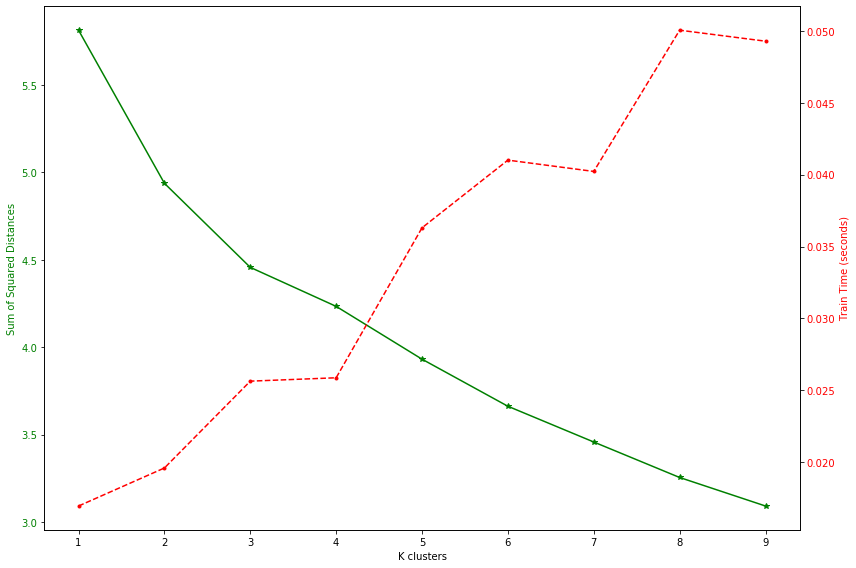

In [41]:
plt.rcParams["figure.figsize"] = (12, 8)

fig, ax1 = plt.subplots()

ax1.set_xlabel("K clusters")
ax1.set_ylabel("Sum of Squared Distances", color = "green")
ax1.plot(k_range, squared_distances, "g*-")
ax1.tick_params(axis = "y", labelcolor = "green")

ax2 = ax1.twinx()
ax2.set_ylabel("Train Time (seconds)", color = "red")
ax2.plot(k_range, train_times, "r.--")
ax2.tick_params(axis = "y", labelcolor = "red")

fig.tight_layout()
plt.show()

Based on the above graph, the optimal number of clusters is around <b>5</b>. Set <b>K</b> to value <b>5</b>.

In [42]:
# Set the optimal number of clusters – 5 clusters
k = 5

# Run K-means clustering
k_means = KMeans(n_clusters = k).fit(df_milan_clustering)

Create a new dataframe that includes the clusters as well as the top **TEN** venues for each district in Milan, Italy.

In [43]:
df_w_clusters = df
df_w_clusters["Cluster Label"] = k_means.labels_

df_milan_venues_w_clusters = df_milan_venues
df_milan_venues_w_clusters["Cluster Label"] = df_milan_venues_w_clusters\
    .apply(lambda row: int(df_w_clusters.loc[df_w_clusters["Name"] == row["District Name"]]["Cluster Label"]),
           axis = 1)
df_milan_venues_w_clusters.sample(16)

,District Name,District Latitude,District Longitude,Venue Name,Venue Category,Venue Latitude,Venue Longitude,Cluster Label
1456,"Porta Nuova, Milan, Italy",45.47685,9.19192,Giolina e Angelo,Jewelry Store,45.475766,9.187295,1
2634,"Trenno, Milan, Italy",45.49225,9.10518,Centro sportivo viscontini,Soccer Field,45.489996,9.102390,1
2568,"Stazione di Milano Centrale, Milan, Italy",45.46439,9.18659,La Locanda Del Gatto Rosso,Italian Restaurant,45.465615,9.190565,1
903,"Monluè, Milan, Italy",45.45234,9.25377,Rockspot,Climbing Gym,45.453770,9.252592,1
804,"Greco, Milan, Italy",45.49702,9.21213,Club 2D,College Gym,45.498544,9.219552,1
1318,"Porta Magenta, Milan, Italy",45.46582,9.17800,Ghe Sem,Dim Sum Restaurant,45.468189,9.172775,1
1026,"Nosedo, Milan, Italy",45.43382,9.22137,Mò Comfort Food Cafè,Snack Place,45.440086,9.223644,3
2216,"Portello, Milan, Italy",45.48980,9.14631,Best Western Hotel Mirage,Hotel,45.494748,9.142028,1
1464,"Porta Nuova, Milan, Italy",45.47685,9.19192,Le Vrai,French Restaurant,45.479701,9.194901,1
1454,"Porta Nuova, Milan, Italy",45.47685,9.19192,N'Ombra de Vin,Wine Bar,45.473452,9.187873,1


In [44]:
df_milan_onehot_cluster_grouped = df_milan_onehot.drop(["District Name"], axis = 1)
df_milan_onehot_cluster_grouped

# Add district column back to the dataframe
df_milan_onehot_cluster_grouped["Cluster Label"] = df_milan_venues_w_clusters["Cluster Label"] 
df_milan_onehot_cluster_grouped = df_milan_onehot_cluster_grouped[[df_milan_onehot_cluster_grouped.columns[-1]] +
                                                                  list(df_milan_onehot_cluster_grouped.columns[:-1])]
# Group by
df_milan_onehot_cluster_grouped = df_milan_onehot_cluster_grouped.groupby("Cluster Label").mean().reset_index()
df_milan_onehot_cluster_grouped.head()

,Cluster Label,Accessories Store,Adult Education Center,African Restaurant,Airport,Airport Terminal,American Restaurant,Amphitheater,Argentinian Restaurant,Art Gallery,...,Video Game Store,Vietnamese Restaurant,Volleyball Court,Watch Shop,Whisky Bar,Wine Bar,Wine Shop,Winery,Women's Store,Yoga Studio
0,0,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000
1,1,0.003013,0.000753,0.00113,0.000377,0.000753,0.001883,0.000377,0.001883,0.007533,...,0.000377,0.000377,0.000753,0.000377,0.000377,0.013183,0.001883,0.00113,0.003013,0.000377
2,2,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000
3,3,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.006410,...,0.000000,0.000000,0.006410,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000
4,4,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000


In [45]:
top_limit = 12

def most_common_venues(row, top_venues_limit):
    venue_categories_sorted = row.iloc[1:].sort_values(ascending = False)
    return venue_categories_sorted.index.values[:top_venues_limit]

# Create the columns according to number of top venues limit
columns = ["District Name"]
indicators = ["st", "nd", "rd", "th"]

for idx in np.arange(top_limit):
    try:
        columns.append('{}{} Most Common Venue'.format(idx + 1, indicators[min(idx, len(indicators))]))
    except:
        columns.append('{}th Most Common Venue'.format(idx + 1))

# Create the new dataframe
df_milan_sorted_top = pd.DataFrame(columns = columns)
df_milan_sorted_top["District Name"] = df_milan_grouped["District Name"]

for idx in np.arange(df_milan_grouped.shape[0]):
    df_milan_sorted_top.iloc[idx, 1:] = most_common_venues(df_milan_grouped.iloc[idx, :], top_limit)

# View the 12 most common venue categories for the first 12 districts in Milan
df_milan_sorted_top.head(12)

,District Name,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,11th Most Common Venue,12th Most Common Venue
0,"Affori, Milan, Italy",Hotel,Pizza Place,Park,Soccer Field,Italian Restaurant,Café,Skate Park,Shipping Store,Salon / Barbershop,Rock Club,Cocktail Bar,Pool Hall
1,"Assiano, Milan, Italy",Pizza Place,Yoga Studio,Filipino Restaurant,Event Space,Fabric Shop,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Film Studio,Dumpling Restaurant,Fish & Chips Shop
2,"Baggio, Milan, Italy",Supermarket,Café,Plaza,Italian Restaurant,Bus Station,Campground,Park,Japanese Restaurant,Bar,Volleyball Court,Pizza Place,Cupcake Shop
3,"Barona, Milan, Italy",Soccer Field,Café,Japanese Restaurant,Theater,Bakery,Athletics & Sports,Trattoria/Osteria,Brewery,Tennis Stadium,Pub,Event Space,Food & Drink Shop
4,"Bicocca, Milan, Italy",Café,Italian Restaurant,Sandwich Place,Steakhouse,Sushi Restaurant,Pizza Place,Hotel,Multiplex,Restaurant,Plaza,Supermarket,Gym
5,"Bovisa, Milan, Italy",Italian Restaurant,Café,Pizza Place,Snack Place,Piadineria,Plaza,Ice Cream Shop,Smoke Shop,Sicilian Restaurant,Kebab Restaurant,Steakhouse,Music Store
6,"Bovisasca, Milan, Italy",Clothing Store,Shoe Store,Soccer Field,Restaurant,Café,Cosmetics Shop,Pizza Place,Supermarket,Park,Health & Beauty Service,Chinese Restaurant,Electronics Store
7,"Brera, Milan, Italy",Italian Restaurant,Hotel,Boutique,Ice Cream Shop,Wine Bar,Plaza,Restaurant,Café,Theater,Pizza Place,Arts & Crafts Store,Cocktail Bar
8,"Bruzzano, Milan, Italy",Italian Restaurant,Bakery,Pizza Place,Football Stadium,Gift Shop,Diner,Train Station,Gym / Fitness Center,Bus Station,Ice Cream Shop,Fish & Chips Shop,Film Studio
9,"Calvairate, Milan, Italy",Italian Restaurant,Park,Pizza Place,Supermarket,Hotel,Ice Cream Shop,Bakery,Market,Other Nightlife,Tanning Salon,Bar,Cocktail Bar


## Visualize Districts and Their Top Venues

In [46]:
# Define the method for displaying to venues for a districs
def list_top_venues_for_district(district_name):
    df = df_milan_sorted_top.loc[df_milan_sorted_top["District Name"] == district_name]
    print([values for name, values in df.iterrows()][0])

# Create the dropdown and output widgets
dropdown = widgets.Dropdown(
    options = list(df_milan_sorted_top["District Name"]),
    description = "District:",
)
output = widgets.interactive_output(list_top_venues_for_district, {"district_name": dropdown})

# Display the widgets inside a vertical box
widgets.VBox([dropdown, output])